In [1]:
import numpy as np
import matplotlib.pyplot as plt
# set seed
np.random.seed(0)

In [2]:

class ThompsonSamplingBandit:
    def __init__(self, num_arms: int):
        """
        Initializes the Thompson Sampling multi-armed bandit.
        
        :param num_arms: Number of arms (variants of the website).
        """
        self.num_arms = num_arms
        # Initialize Beta distribution parameters (alpha, beta) for each arm
        # alpha and beta represent the number of successes and failures observed for each arm.
        self.alpha = np.ones(num_arms)
        self.beta = np.ones(num_arms)
        self.arm_counts = np.zeros(num_arms)
        self.conversions = np.zeros(num_arms)

    def select_arm(self):
        """
        Selects an arm based on Thompson Sampling: sample from each arm's Beta distribution
        and select the arm with the highest sampled value.
        
        :return: Index of the selected arm.
        """
        # Sample from the Beta distribution for each arm
        sampled_values = np.random.beta(self.alpha, self.beta)
        return np.argmax(sampled_values)

    def update(self, arm: int, reward: float):
        """
        Updates the Beta distribution parameters for the selected arm based on the observed reward.
        
        :param arm: The selected arm (website version).
        :param reward: The observed reward (conversion: 0 or 1).
        """
        if reward == 1:
            # Increment the alpha parameter for a success (conversion)
            self.alpha[arm] += 1
            self.conversions[arm] += 1
        else:
            # Increment the beta parameter for a failure (no conversion)
            self.beta[arm] += 1
        self.arm_counts[arm] += 1
        
    def simulate(self, num_iterations: int, reward_function):
        """
        Simulates the bandit over multiple iterations.
        
        :param num_iterations: Number of rounds (e.g., visitors to the website).
        :param reward_function: A function that returns the reward (conversions) for a given arm.
        :return: None
        """
        rewards = []
        reward_allocations = np.zeros((num_iterations, self.num_arms))
        for i in range(num_iterations):
            arm = self.select_arm()
            reward = reward_function(arm)
            self.update(arm, reward)
            reward_allocations[i, arm] = reward
            rewards.append(reward)
        return np.cumsum(rewards), reward_allocations  # Cumulative reward over time for plotting


In [3]:
class EpsilonGreedyBandit:
    def __init__(self, num_arms: int, epsilon: float = 0.3, alpha: float = 0.1):
        """
        Initializes the epsilon-greedy multi-armed bandit.
        
        :param num_arms: Number of arms (variants of the website).
        :param epsilon: Probability of exploration (choosing a random arm).
        :param alpha: Learning rate for updating the estimated reward for each arm.
        """
        self.num_arms = num_arms
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha  # Learning rate for updating Q-values
        
        # Initialize the estimated reward (Q-values) for each arm to 0
        self.q_values = np.zeros(num_arms)
        
        # Track the number of times each arm (website version) has been selected
        self.arm_counts = np.zeros(num_arms)
        self.conversions = np.zeros(num_arms)
    
    def select_arm(self):
        """
        Selects an arm using the epsilon-greedy strategy.
        
        :return: Index of the selected arm.
        """
        if np.random.rand() < self.epsilon:
            # Exploration: Select a random arm
            return np.random.randint(self.num_arms)
        else:
            # Exploitation: Select the arm with the highest Q-value
            return np.argmax(self.q_values)

    def update_q_value(self, arm: int, reward: float):
        """
        Updates the estimated reward (Q-value) for the selected arm based on the observed reward.
        
        :param arm: The arm (website version) that was selected.
        :param reward: The observed reward (conversions).
        """
        self.arm_counts[arm] += 1
        self.conversions[arm] += reward
        self.q_values[arm] += self.alpha * (reward - self.q_values[arm])

    def simulate(self, num_iterations: int, reward_function):
        """
        Simulates the bandit over multiple iterations.
        
        :param num_iterations: Number of rounds (e.g., visitors to the website).
        :param reward_function: A function that returns the reward (conversions) for a given arm.
        :return: None
        """
        rewards = []
        reward_allocations = np.zeros((num_iterations, self.num_arms))
        for i in range(num_iterations):
            arm = self.select_arm()
            reward = reward_function(arm)
            self.update_q_value(arm, reward)
            reward_allocations[i, arm] = reward
            rewards.append(reward)
        return np.cumsum(rewards), reward_allocations  # Cumulative reward over time for plotting


In [4]:
class TraditionalABTest:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.arm_counts = np.zeros(num_arms)
        self.conversions = np.zeros(num_arms)
        
    def select_arm(self):
        # Even distribution for traditional A/B/C test
        return np.random.randint(self.num_arms)
    
    def update(self, arm: int, reward: float):
        self.arm_counts[arm] += 1
        self.conversions[arm] += reward
        
    def simulate(self, num_iterations: int, reward_function):
        """
        Simulates the bandit over multiple iterations.
        
        :param num_iterations: Number of rounds (e.g., visitors to the website).
        :param reward_function: A function that returns the reward (conversions) for a given arm.
        :return: None
        """
        rewards = []
        reward_allocations = np.zeros((num_iterations, self.num_arms))
        for i in range(num_iterations):
            arm = self.select_arm()
            reward = reward_function(arm)
            reward_allocations[i, arm] = reward
            self.update(arm, reward)
            reward_allocations[i, arm] = reward
            rewards.append(reward)
        return np.cumsum(rewards), reward_allocations  # Cumulative reward over time for plotting


In [5]:
def reward_function(arm: int):
    """
    Simulate the reward (conversion rate) for a given arm.
    
    :param arm: The arm (website version) selected.
    :return: Reward (number of conversions or success probability).
    """
    conversion_rates = [0.1, 0.15, 0.13]  # Conversion rates for different website variants
    return np.random.binomial(1, conversion_rates[arm])  # Simulate a conversion (1 or 0)

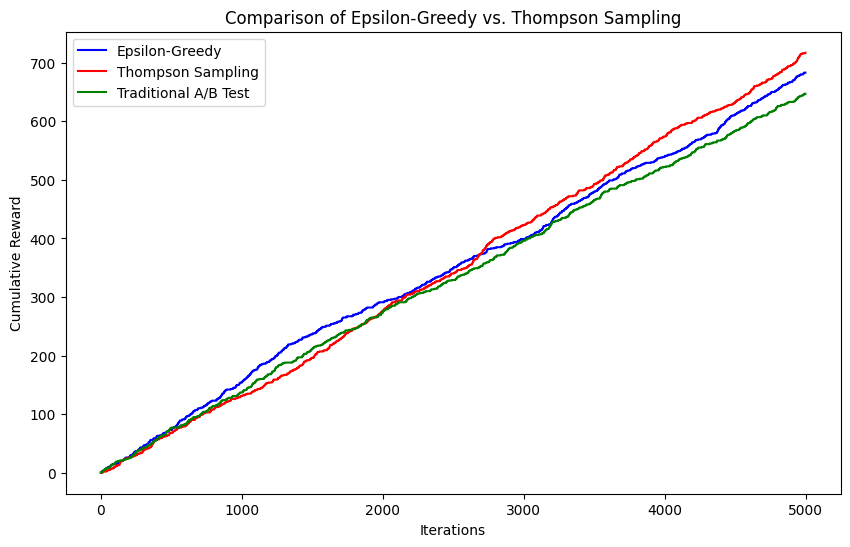

In [6]:

# --- Main Execution ---
num_arms = 3  # Let's say we have 3 different website versions in the A/B test
epsilon = 0.3  # 10% exploration
visitors = 5000  # Simulate visitors interacting with the website

# Create instances for both algorithms
epsilon_bandit = EpsilonGreedyBandit(num_arms, epsilon)
thompson_bandit = ThompsonSamplingBandit(num_arms)
traditional = TraditionalABTest(num_arms)

# Simulate the bandits
epsilon_rewards, _ = epsilon_bandit.simulate(visitors, reward_function)
thompson_rewards, _ = thompson_bandit.simulate(visitors, reward_function)
tradional_rewards, _ = traditional.simulate(visitors, reward_function)

# Plot the cumulative rewards for both strategies
plt.figure(figsize=(10, 6))
plt.plot(epsilon_rewards, label="Epsilon-Greedy", color='blue')
plt.plot(thompson_rewards, label="Thompson Sampling", color='red')
plt.plot(tradional_rewards, label="Traditional A/B Test", color='green')
plt.xlabel("Iterations")
plt.ylabel("Cumulative Reward")
plt.title("Comparison of Epsilon-Greedy vs. Thompson Sampling")
plt.legend()
plt.show()

In [7]:
# Print the total number of conversions for each strategy

print("Total Conversions (Epsilon-Greedy):", epsilon_rewards[-1])
print("Total Conversions (Thompson Sampling):", thompson_rewards[-1])
print("Total Conversions (Traditional A/B Test):", tradional_rewards[-1])




Total Conversions (Epsilon-Greedy): 683
Total Conversions (Thompson Sampling): 717
Total Conversions (Traditional A/B Test): 647


In [8]:
# print the conversion rate for each arm for each strategy
print("Conversion Rates (Epsilon-Greedy):", epsilon_bandit.conversions / epsilon_bandit.arm_counts)
print("Conversion Rates (Thompson Sampling):", thompson_bandit.conversions / thompson_bandit.arm_counts)
print("Conversion Rates (Traditional A/B Test):", traditional.conversions / traditional.arm_counts)


Conversion Rates (Epsilon-Greedy): [0.1105142  0.14268868 0.14842579]
Conversion Rates (Thompson Sampling): [0.08791209 0.14767568 0.09326425]
Conversion Rates (Traditional A/B Test): [0.10148368 0.14752116 0.13967489]


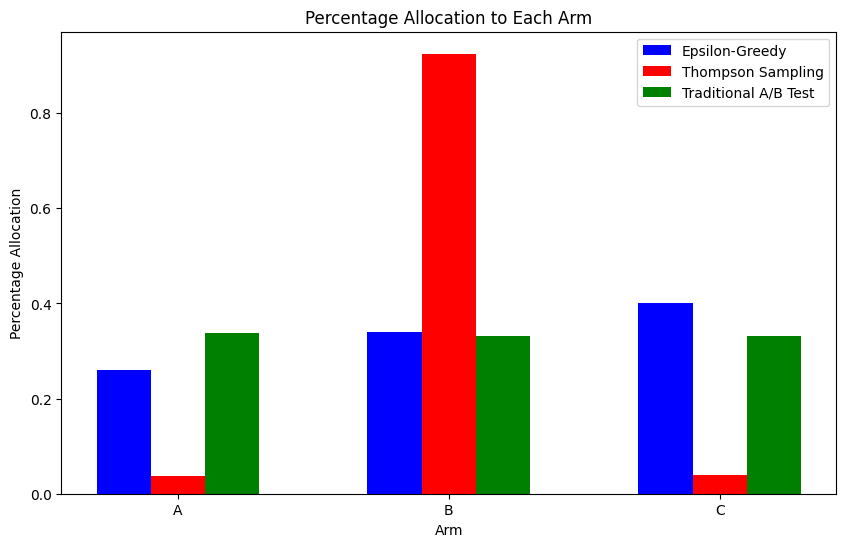

In [9]:
# plot the percentage allocation to each arm for each strategy
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_arms) - 0.2, epsilon_bandit.arm_counts / visitors, width=0.2, label="Epsilon-Greedy", color='blue')
plt.bar(np.arange(num_arms), thompson_bandit.arm_counts / visitors, width=0.2, label="Thompson Sampling", color='red')
plt.bar(np.arange(num_arms) + 0.2, traditional.arm_counts / visitors, width=0.2, label="Traditional A/B Test", color='green')
plt.xlabel("Arm")
plt.ylabel("Percentage Allocation")
plt.title("Percentage Allocation to Each Arm")
plt.xticks(np.arange(num_arms), ['A', 'B', 'C'])
plt.legend()
plt.show()


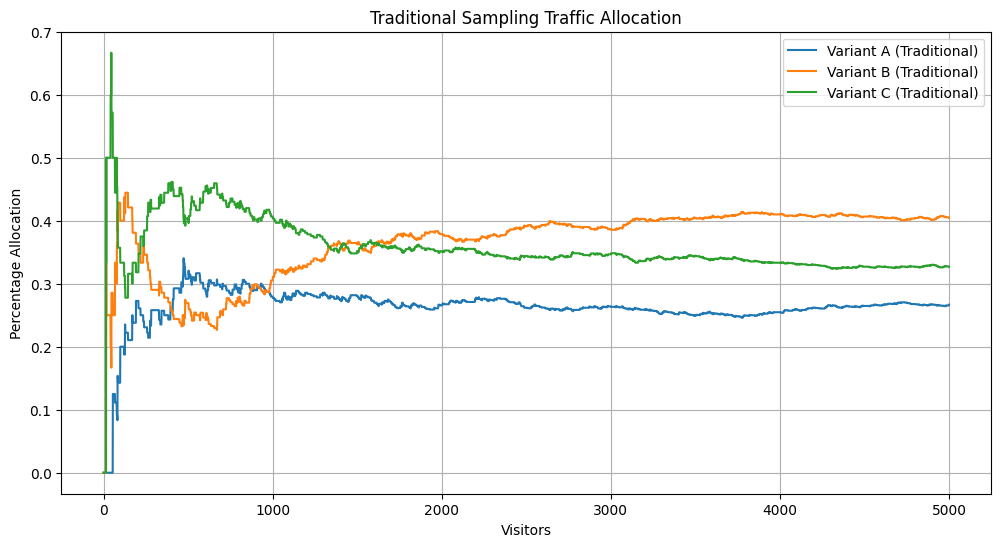

In [10]:
# plot the percentage allocation for each number of visitors for traditional sampling  
_, rewards = traditional.simulate(visitors, reward_function)
traditional_cumulative_rewards = np.array(rewards).cumsum(axis=0)
# Plot allocation percentages
plt.figure(figsize=(12, 6))
for i in range(num_arms):
    plt.plot(traditional_cumulative_rewards[:,i]/(traditional_cumulative_rewards.sum(axis=1)+1), 
             label=f'Variant {chr(65+i)} (Traditional)')
plt.title('Traditional Sampling Traffic Allocation')
plt.xlabel('Visitors')
plt.ylabel('Percentage Allocation')
plt.legend()
plt.grid(True)


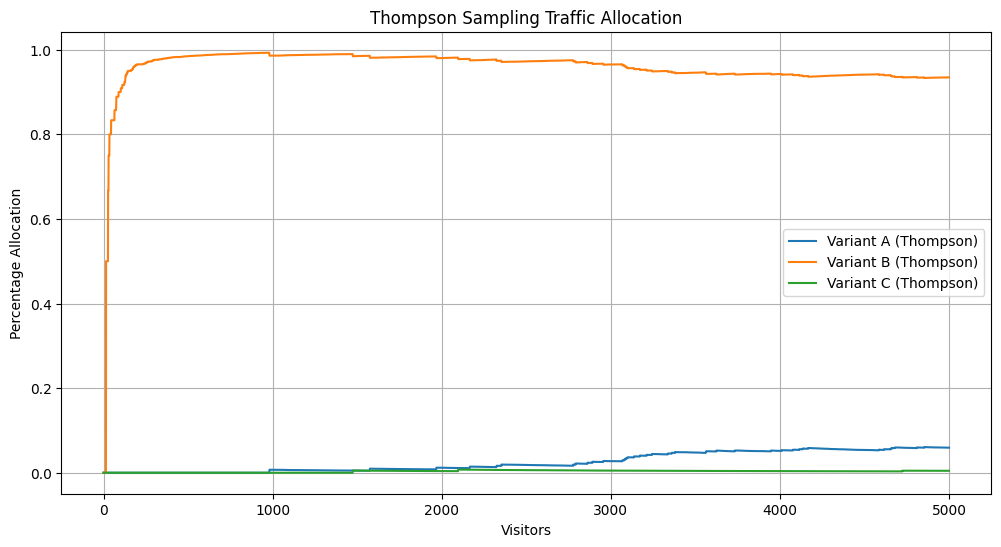

In [11]:
# plot the percentage allocation for each number of visitors for traditional sampling  
_, rewards = thompson_bandit.simulate(visitors, reward_function)
thompson_cumulative_rewards = np.array(rewards).cumsum(axis=0)
# Plot allocation percentages
plt.figure(figsize=(12, 6))
for i in range(num_arms):
    plt.plot(thompson_cumulative_rewards[:,i]/(thompson_cumulative_rewards.sum(axis=1)+1), 
             label=f'Variant {chr(65+i)} (Thompson)')
plt.title('Thompson Sampling Traffic Allocation')
plt.xlabel('Visitors')
plt.ylabel('Percentage Allocation')
plt.legend()
plt.grid(True)


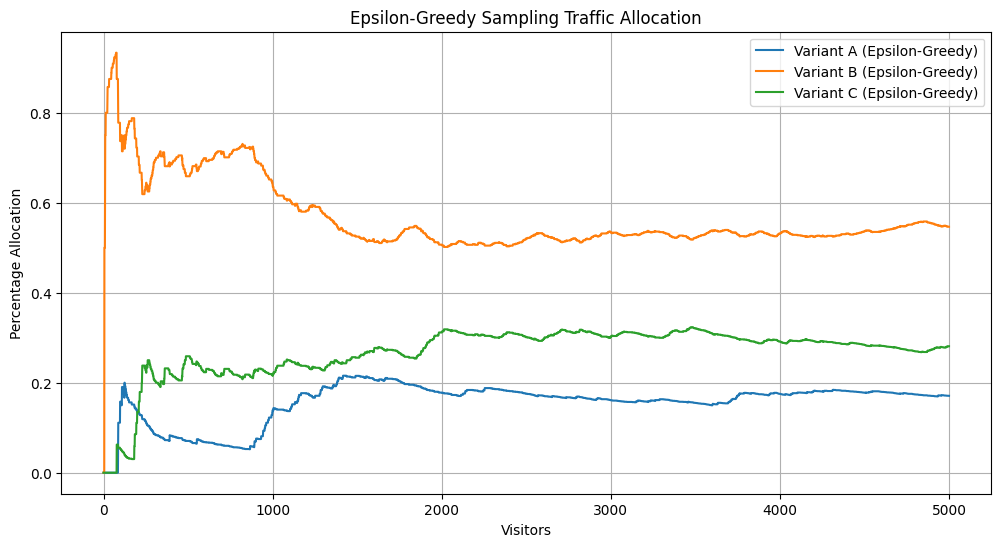

In [12]:
# plot the percentage allocation for each number of visitors for traditional sampling  
_, rewards = epsilon_bandit.simulate(visitors, reward_function)
epsilon_cumulative_rewards = np.array(rewards).cumsum(axis=0)
# Plot allocation percentages
plt.figure(figsize=(12, 6))
for i in range(num_arms):
    plt.plot(epsilon_cumulative_rewards[:,i]/(epsilon_cumulative_rewards.sum(axis=1)+1), 
             label=f'Variant {chr(65+i)} (Epsilon-Greedy)')
plt.title('Epsilon-Greedy Sampling Traffic Allocation')
plt.xlabel('Visitors')
plt.ylabel('Percentage Allocation')
plt.legend()
plt.grid(True)
